# Coding for bee queen presence classification through sound

## Package installations and data imports

Note: you may need to restart the kernel to use updated packages.


In [77]:
#packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [101]:


# Read
beeog = pd.read_csv('all_data_updated.csv',delimiter=';')

list(beeog.columns)

beeog.columns.values[2] = 'date'

# Convert the 'date' column to datetime format
beeog['date'] = pd.to_datetime(beeog['date'], format='%Y/%m/%d %H:%M')

beeog.head()

,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022-06-08 14:52:00,36.42,30.29,1007.45,26.68,52,1013,8.75,...,0,37.29,-121.95,2022-06-08--14-52-28_1.raw,1,2,8,0,0.583,0
1,1,5,2022-06-08 15:51:00,33.56,33.98,1006.93,25.99,53,1012,10.29,...,0,37.29,-121.95,2022-06-08--15-51-41_1.raw,1,2,8,0,0.625,0
2,1,5,2022-06-08 17:21:00,29.01,42.73,1006.68,24.49,56,1012,8.75,...,0,37.29,-121.95,2022-06-08--17-21-53_1.raw,0,0,8,1,0.708,1
3,1,5,2022-06-08 18:20:00,30.51,36.74,1006.68,22.97,59,1012,8.23,...,0,37.29,-121.95,2022-06-08--18-20-59_1.raw,0,0,8,1,0.750,1
4,1,5,2022-06-08 19:20:00,30.32,35.55,1006.58,21.52,61,1012,7.20,...,0,37.29,-121.95,2022-06-08--19-20-04_1.raw,0,0,8,1,0.792,1


Hive only data

In [120]:
# Define a function to determine the new queen status
def determine_queen_status(row):
    if row['queen presence'] == 1 and row['queen acceptance'] == 0:
        return 'Queen Present'
    elif row['queen presence'] == 1 and row['queen acceptance'] == 1:
        return 'Queen Being Introduced (Bad)'
    elif row['queen presence'] == 1 and row['queen acceptance'] == 2:
        return 'New Queen Present'
    elif row['queen presence'] == 0 and row['queen acceptance'] == 0:
        return 'No Queen'
    else:
        return 'Unknown'

#new column with the determined queen status
beeog['new_queen_status'] = beeog.apply(determine_queen_status, axis=1)

#only the specified columns
selected_columns = [
    'date', 'device', 'hive number', 'hive temp', 'hive humidity', 'hive pressure', 
    'file name', 'queen presence', 'queen acceptance', 'new_queen_status'
]
new_dataset = beeog[selected_columns]

# Display 
new_dataset.head()


,date,device,hive number,hive temp,hive humidity,hive pressure,file name,queen presence,queen acceptance,new_queen_status
0,2022-06-08 14:52:00,1,5,36.42,30.29,1007.45,2022-06-08--14-52-28_1.raw,1,2,New Queen Present
1,2022-06-08 15:51:00,1,5,33.56,33.98,1006.93,2022-06-08--15-51-41_1.raw,1,2,New Queen Present
2,2022-06-08 17:21:00,1,5,29.01,42.73,1006.68,2022-06-08--17-21-53_1.raw,0,0,No Queen
3,2022-06-08 18:20:00,1,5,30.51,36.74,1006.68,2022-06-08--18-20-59_1.raw,0,0,No Queen
4,2022-06-08 19:20:00,1,5,30.32,35.55,1006.58,2022-06-08--19-20-04_1.raw,0,0,No Queen


## Data analysis

### Dataset overview

In [102]:
#num of rows and columns
print(f'The dataset contains {beeog.shape[0]} rows and {beeog.shape[1]} columns.')

#unique values for each column
unique_values_count = beeog.nunique().reset_index()
unique_values_count.columns = ['Column', 'Unique Values']

#num of missing values for each column
missing_values_count = beeog.isnull().sum().reset_index()
missing_values_count.columns = ['Column', 'Missing Values']

# both tables into one
combined_summary = pd.merge(unique_values_count, missing_values_count, on='Column')

# Displaying
combined_summary

The dataset contains 1275 rows and 23 columns.


,Column,Unique Values,Missing Values
0,device,2,0
1,hive number,4,0
2,date,1126,0
3,hive temp,1022,0
4,hive humidity,1151,0
5,hive pressure,699,0
6,weather temp,828,4
7,weather humidity,65,0
8,weather pressure,14,0
9,wind speed,34,4


### Dateset analysis of time, unique hives and queen presence

Creating a timeline to visualize what dates the data was collected on.

Seeing what days werent recorded for each hive

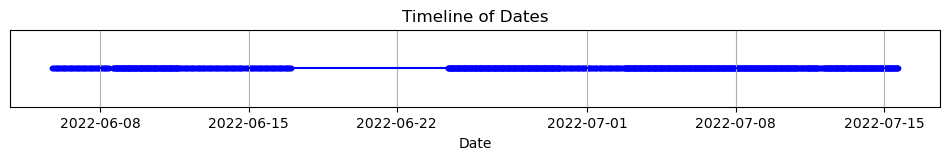

(Timestamp('2022-06-05 17:41:00'), Timestamp('2022-07-15 15:28:00'), 39)

In [103]:
#timeline of the date column
plt.figure(figsize=(12, 1))
plt.hlines(1, beeog['date'].min(), beeog['date'].max(), colors='blue')
plt.scatter(beeog['date'], [1]*len(beeog), color='blue', s=10)
plt.title('Timeline of Dates')
plt.xlabel('Date')
plt.yticks([])
plt.grid(True)
plt.show()

# calc the overall time span
start_date = beeog['date'].min()
end_date = beeog['date'].max()
total_days = (end_date - start_date).days

#result
start_date, end_date, total_days

Identifying date gaps

In [113]:
# list of all unique dates in the dataset
all_dates = pd.date_range(start=beeog['date'].min().date(), end=beeog['date'].max().date())

missing_days_summary = {}

# Loop through each hive to find missing days
for hive in beeog['hive number'].unique():
    hive_data = beeog[beeog['hive number'] == hive]
    
    recorded_dates = set(hive_data['date'].dt.date)
    
    missing_dates = set(all_dates.date) - recorded_dates
    
    # Add  missing dates and the total count 
    missing_days_summary[hive] = {
        'missing_dates': sorted(missing_dates),
        'total_missing_days': len(missing_dates)
    }

# merge the summary dictionary to a DataFrame 
missing_days_df = pd.DataFrame([
    {'Hive Number': hive, 'Missing Dates': ', '.join(map(str, data['missing_dates'])), 'Total Missing Days': data['total_missing_days']}
    for hive, data in missing_days_summary.items()
])

# Display 
missing_days_df

,Hive Number,Missing Dates,Total Missing Days
0,5,"2022-06-05, 2022-06-06, 2022-06-07, 2022-06-12...",35
1,3,"2022-06-14, 2022-06-15, 2022-06-16, 2022-06-17...",32
2,4,"2022-06-05, 2022-06-06, 2022-06-07, 2022-06-08...",19
3,1,"2022-06-05, 2022-06-06, 2022-06-07, 2022-06-08...",17


In [114]:
#list of all unique dates in the dataset
all_dates = pd.date_range(start=beeog['date'].min().date(), end=beeog['date'].max().date())

#  dictionaries to store the results
missing_days_summary = {}
missing_days_ranges = []

# Function to find the ranges of missing dates
def find_missing_date_ranges(missing_dates):
    missing_dates = sorted(missing_dates)
    ranges = []
    start_date = missing_dates[0]
    end_date = missing_dates[0]

    for date in missing_dates[1:]:
        if date == end_date + pd.Timedelta(days=1):
            end_date = date
        else:
            ranges.append((start_date, end_date))
            start_date = date
            end_date = date
    ranges.append((start_date, end_date))
    return ranges

# Loop through each hive to find missing days
for hive in beeog['hive number'].unique():
    hive_data = beeog[beeog['hive number'] == hive]
    
    recorded_dates = set(hive_data['date'].dt.date)
    
    missing_dates = set(all_dates.date) - recorded_dates
    
    missing_days_summary[hive] = len(missing_dates)
    
    #ranges of missing dates
    ranges = find_missing_date_ranges(missing_dates)
    for start_date, end_date in ranges:
        missing_days_ranges.append({'Hive Number': hive, 'Missing Date Range': f'{start_date} - {end_date}'})

# change the missing days summary dictionary to a DataFrame
missing_days_summary_df = pd.DataFrame([
    {'Hive Number': hive, 'Total Missing Days': total_missing_days}
    for hive, total_missing_days in missing_days_summary.items()
])

missing_days_ranges_df = pd.DataFrame(missing_days_ranges)

# Displaying
display(missing_days_summary_df)
display(missing_days_ranges_df)

,Hive Number,Total Missing Days
0,5,35
1,3,32
2,4,19
3,1,17


,Hive Number,Missing Date Range
0,5,2022-06-05 - 2022-06-07
1,5,2022-06-12 - 2022-06-12
2,5,2022-06-15 - 2022-07-15
3,3,2022-06-14 - 2022-07-15
4,4,2022-06-05 - 2022-06-23
5,1,2022-06-05 - 2022-06-13
6,1,2022-06-17 - 2022-06-23
7,1,2022-07-01 - 2022-07-01


Seeing how many data points and time passed there is for each hive

In [92]:
 #Group by hive number and calculate the required metrics
hive_summary = beeog.groupby('hive number').agg(
    data_points=('date', 'size'),
    first_recording=('date', 'min'),
    last_recording=('date', 'max')
).reset_index()

# calc the amount of time passed in days between first and last recording
hive_summary['days_between'] = (hive_summary['last_recording'] - hive_summary['first_recording']).dt.days

# Display 
hive_summary

,hive number,data_points,first_recording,last_recording,days_between
0,1,518,2022-06-14 20:15:00,2022-07-15 15:28:00,30
1,3,189,2022-06-05 17:41:00,2022-06-13 16:45:00,7
2,4,471,2022-06-24 10:03:00,2022-07-15 15:12:00,21
3,5,97,2022-06-08 14:52:00,2022-06-14 17:49:00,6


Seeing which hives had no queen at some point

In [100]:
# filt the data for rows where queen presence is 0
no_queen_data = beeog[beeog['queen presence'] == 0]

# unique hives that had no queen presence at some point
hives_without_queen = no_queen_data['hive number'].unique()

# Display 
hives_without_queen

array([1, 3, 4, 5], dtype=int64)

Seeing how queen presence changed over time for each hive

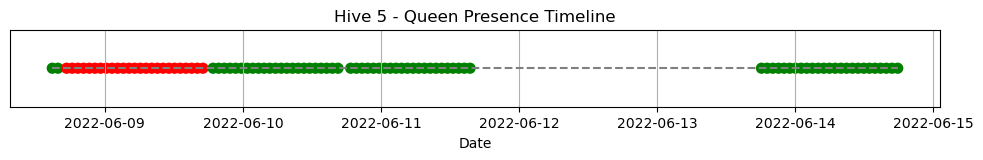

In [125]:
# Specify the hive number you want to analyze
hive_number = 5  # Change this to the desired hive number

# Filter the data for the specified hive
hive_data = beeog[beeog['hive number'] == hive_number]

#color map for queen presence
color_map = {0: 'red', 1: 'green'}

#timeline of the queen presence for the specific hive
plt.figure(figsize=(12, 1))
plt.hlines(1, hive_data['date'].min(), hive_data['date'].max(), colors='grey', linestyles='dashed')
plt.scatter(hive_data['date'], [1]*len(hive_data), c=hive_data['queen presence'].map(color_map), s=50)
plt.title(f'Hive {hive_number} - Queen Presence Timeline')
plt.xlabel('Date')
plt.yticks([])
plt.grid(True)
plt.show()

Creating separate data sets for each hive

In [86]:
#unique hives
unique_hives = beeog['hive number'].unique()

hives_data = {}

#DataFrame for each hive
for hive in unique_hives:
    hive_data = beeog[beeog['hive number'] == hive]
    hive_name = f"hive{hive}"
    hives_data[hive_name] = hive_data

# Display  DataFrame for each hive
for hive_name, hive_data in hives_data.items():
    print(f"{hive_name} DataFrame:")
    display(hive_data.head())

hive5 DataFrame:


,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
0,1,5,2022/06/08 14:52,36.42,30.29,1007.45,26.68,52,1013,8.75,...,0,37.29,-121.95,2022-06-08--14-52-28_1.raw,1,2,8,0,0.583,0
1,1,5,2022/06/08 15:51,33.56,33.98,1006.93,25.99,53,1012,10.29,...,0,37.29,-121.95,2022-06-08--15-51-41_1.raw,1,2,8,0,0.625,0
2,1,5,2022/06/08 17:21,29.01,42.73,1006.68,24.49,56,1012,8.75,...,0,37.29,-121.95,2022-06-08--17-21-53_1.raw,0,0,8,1,0.708,1
3,1,5,2022/06/08 18:20,30.51,36.74,1006.68,22.97,59,1012,8.23,...,0,37.29,-121.95,2022-06-08--18-20-59_1.raw,0,0,8,1,0.750,1
4,1,5,2022/06/08 19:20,30.32,35.55,1006.58,21.52,61,1012,7.20,...,0,37.29,-121.95,2022-06-08--19-20-04_1.raw,0,0,8,1,0.792,1


hive3 DataFrame:


,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
97,2,3,2022/06/05 17:41,29.84,43.53,1007.27,24.15,68,1013,5.14,...,0,37.29,-121.95,2022-06-05--17-41-01_2.raw,1,2,10,5,0.708,0
98,2,3,2022/06/05 18:40,28.14,44.70,1007.48,23.02,71,1013,7.20,...,0,37.29,-121.95,2022-06-05--18-40-08_2.raw,1,2,10,5,0.750,0
99,2,3,2022/06/05 19:39,26.52,46.60,1007.81,21.44,76,1013,6.17,...,0,37.29,-121.95,2022-06-05--19-39-14_2.raw,1,2,10,5,0.792,0
100,2,3,2022/06/05 20:38,25.42,47.82,1008.07,19.82,80,1014,5.66,...,0,37.29,-121.95,2022-06-05--20-38-25_2.raw,1,2,10,5,0.833,0
101,2,3,2022/06/05 21:37,24.54,47.87,1008.55,18.66,82,1014,4.63,...,0,37.29,-121.95,2022-06-05--21-37-36_2.raw,1,2,10,5,0.875,0


hive4 DataFrame:


,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
286,1,4,2022/06/24 10:03,42.76,38.83,1005.69,25.03,43,1012,2.57,...,0,37.29,-121.95,2022-06-24--10-03-35_1.raw,1,2,8,0,0.417,0
287,1,4,2022/06/24 11:03,48.42,20.98,1005.54,27.45,38,1011,3.60,...,0,37.29,-121.95,2022-06-24--11-03-30_1.raw,1,2,8,0,0.458,0
288,1,4,2022/06/24 12:02,47.41,18.39,1005.24,30.37,34,1011,3.09,...,0,37.29,-121.95,2022-06-24--12-02-42_1.raw,1,2,8,0,0.500,0
289,1,4,2022/06/24 13:01,44.55,20.51,1004.74,32.40,35,1010,4.12,...,0,37.29,-121.95,2022-06-24--13-01-08_1.raw,1,2,8,0,0.542,0
290,1,4,2022/06/24 14:00,38.81,25.14,1004.50,33.06,35,1010,4.63,...,0,37.29,-121.95,2022-06-24--14-00-07_1.raw,1,2,8,0,0.583,0


hive1 DataFrame:


,device,hive number,date,hive temp,hive humidity,hive pressure,weather temp,weather humidity,weather pressure,wind speed,...,rain,lat,long,file name,queen presence,queen acceptance,frames,target,time,queen status
757,2,1,2022/06/14 20:15,24.67,24.97,1006.81,21.99,43,1013,6.17,...,0,37.29,-121.95,2022-06-14--20-15-04_2.raw,1,2,10,5,0.833,0
758,2,1,2022/06/14 21:15,22.62,25.40,1006.91,18.93,54,1013,4.63,...,0,37.29,-121.95,2022-06-14--21-15-24_2.raw,1,2,10,5,0.875,0
759,2,1,2022/06/14 22:14,21.58,25.25,1007.42,17.80,60,1013,3.09,...,0,37.29,-121.95,2022-06-14--22-14-39_2.raw,1,2,10,5,0.917,0
760,2,1,2022/06/14 23:18,20.77,25.19,1007.44,16.99,64,1013,3.09,...,0,37.29,-121.95,2022-06-14--23-18-18_2.raw,1,2,10,5,0.958,0
761,2,1,2022/06/15 00:22,20.57,24.59,1007.22,15.94,68,1013,3.09,...,0,37.29,-121.95,2022-06-15--00-22-02_2.raw,1,2,10,5,0.000,0


#### Graphs of temeprature and humidity for hive specific and overall

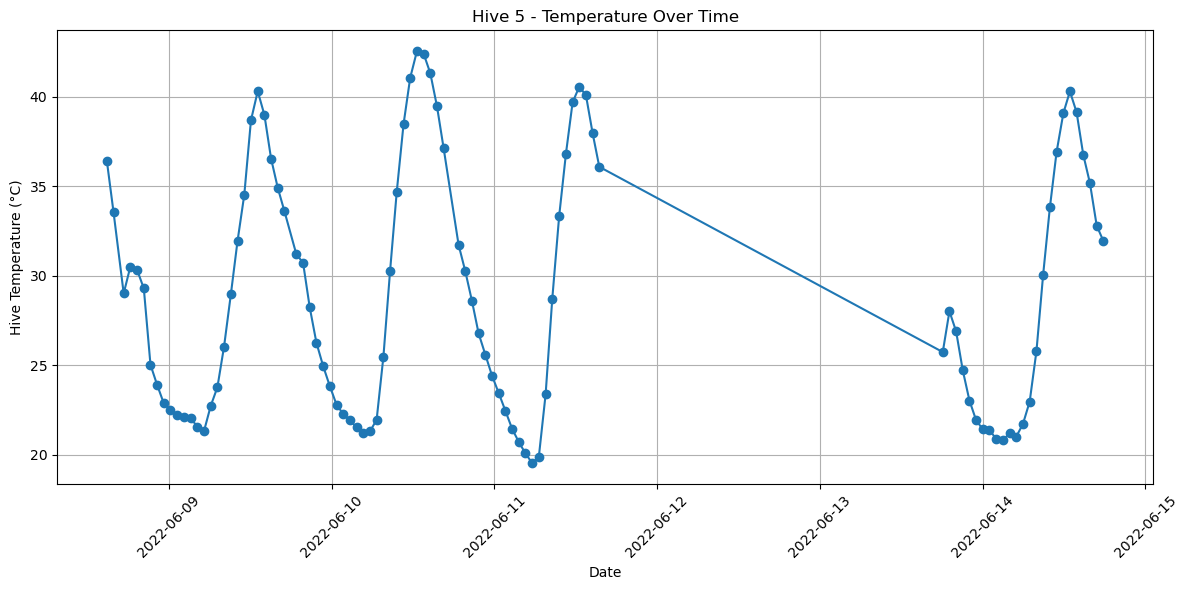

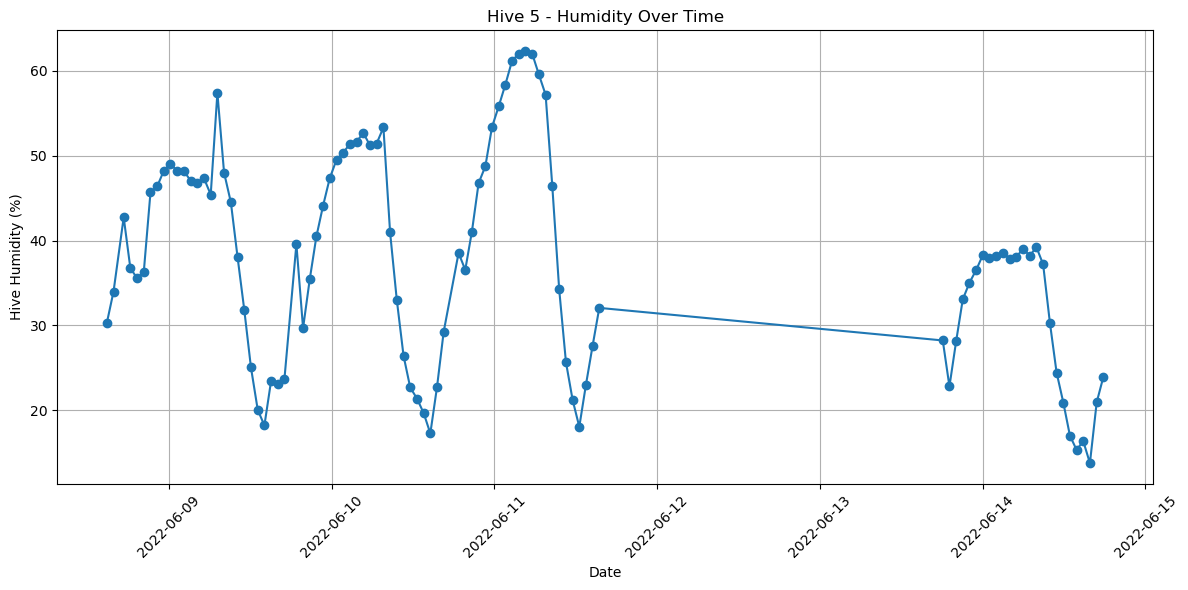

In [127]:
# Specifying the hive number 
hive_number = 5  # this can be changed

# filter  data for the specified hive
hive_data = beeog[beeog['hive number'] == hive_number]

# Plot hive temperature over time
plt.figure(figsize=(12, 6))
plt.plot(hive_data['date'], hive_data['hive temp'], marker='o', linestyle='-')
plt.title(f'Hive {hive_number} - Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Hive Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot hive humidity over time
plt.figure(figsize=(12, 6))
plt.plot(hive_data['date'], hive_data['hive humidity'], marker='o', linestyle='-')
plt.title(f'Hive {hive_number} - Humidity Over Time')
plt.xlabel('Date')
plt.ylabel('Hive Humidity (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

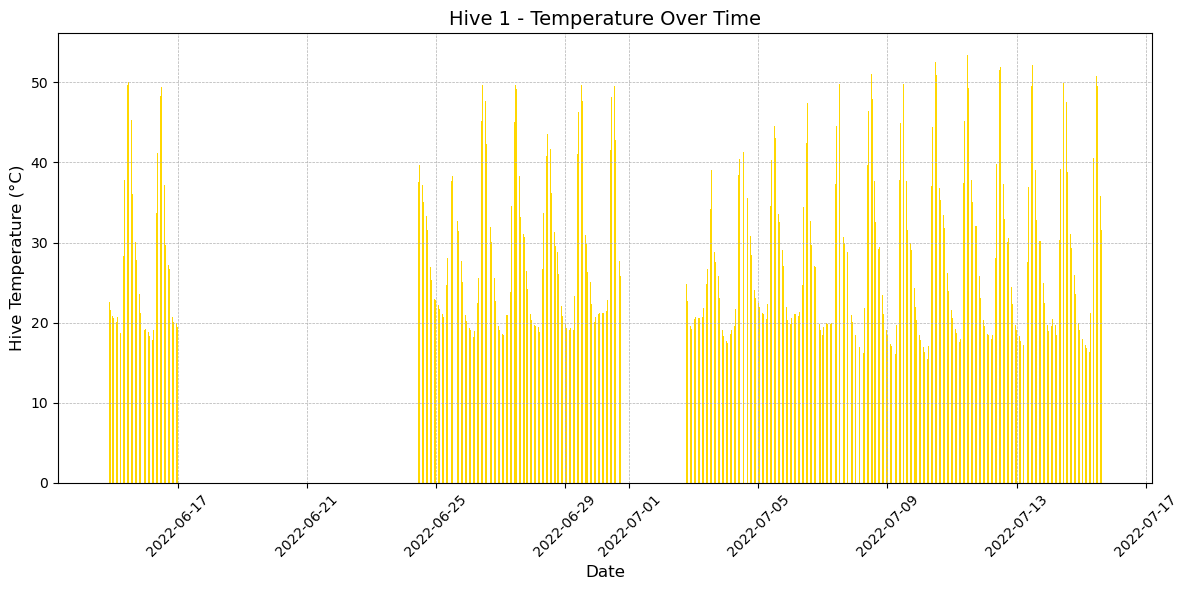

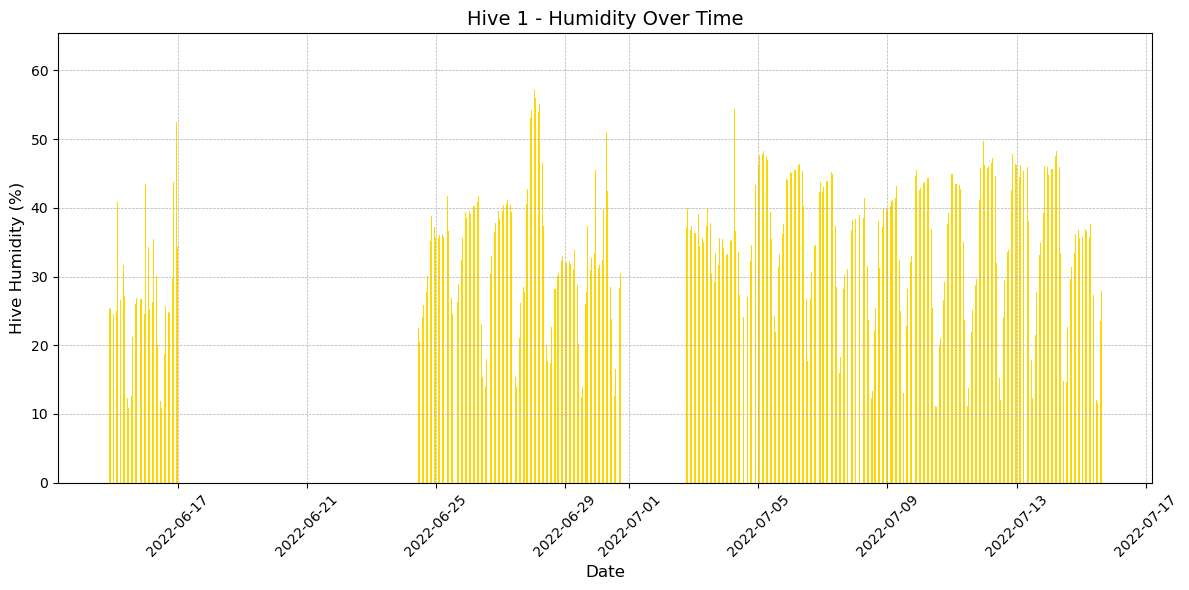

In [128]:
# specify the hive
hive_number = 1  # this can be changed

# Filter the data for the specified hive
hive_data = beeog[beeog['hive number'] == hive_number]

# Plot hive temperature over time as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(hive_data['date'], hive_data['hive temp'], color='#FFD700', width=0.02)
plt.title(f'Hive {hive_number} - Temperature Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hive Temperature (°C)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# Plot hive humidity over time as a bar chart
plt.figure(figsize=(12, 6))
plt.bar(hive_data['date'], hive_data['hive humidity'], color='#FFD700', width=0.02)
plt.title(f'Hive {hive_number} - Humidity Over Time', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Hive Humidity (%)', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

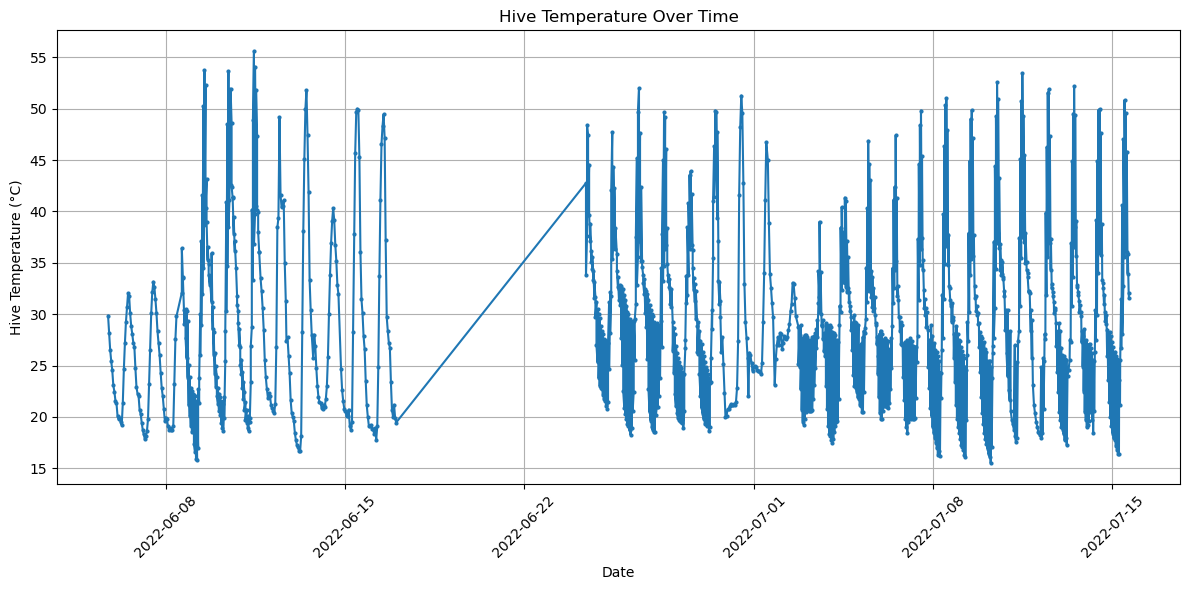

In [96]:
# changing 'date' column to datetime format
beeog['date'] = pd.to_datetime(beeog['date'], format='%Y/%m/%d %H:%M')

# Check for missing or NaN values
beeog = beeog.dropna(subset=['date', 'hive temp'])

# Sort the data by date
beeog = beeog.sort_values('date')

# Plot hive temperature over time
plt.figure(figsize=(12, 6))
plt.plot(beeog['date'], beeog['hive temp'], marker='o', linestyle='-', markersize=2)
plt.title('Hive Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Hive Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


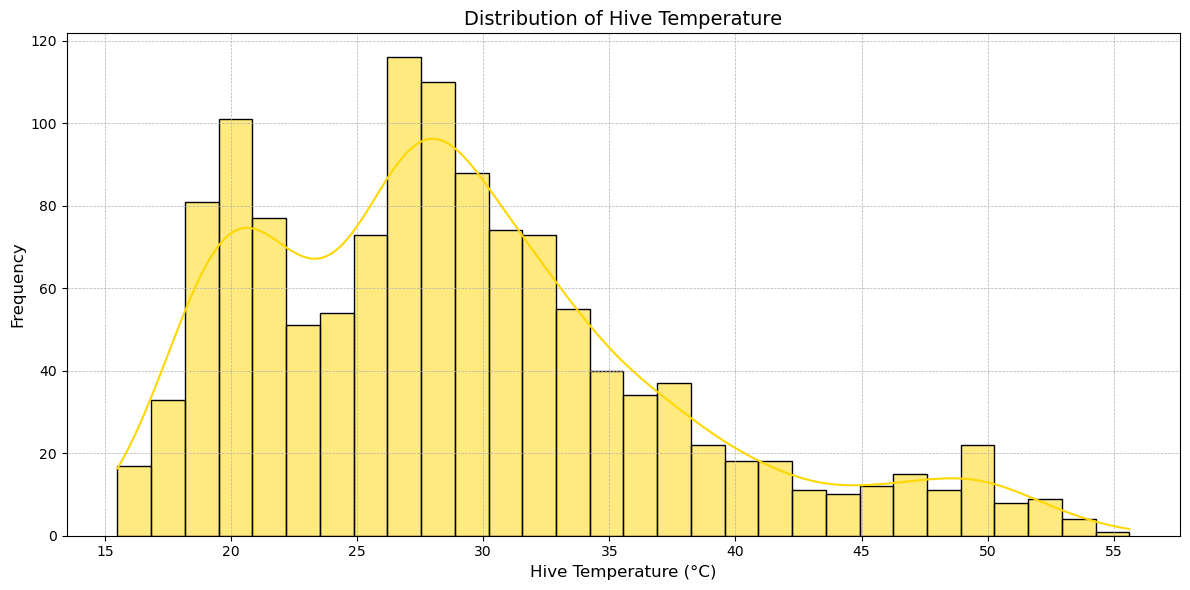

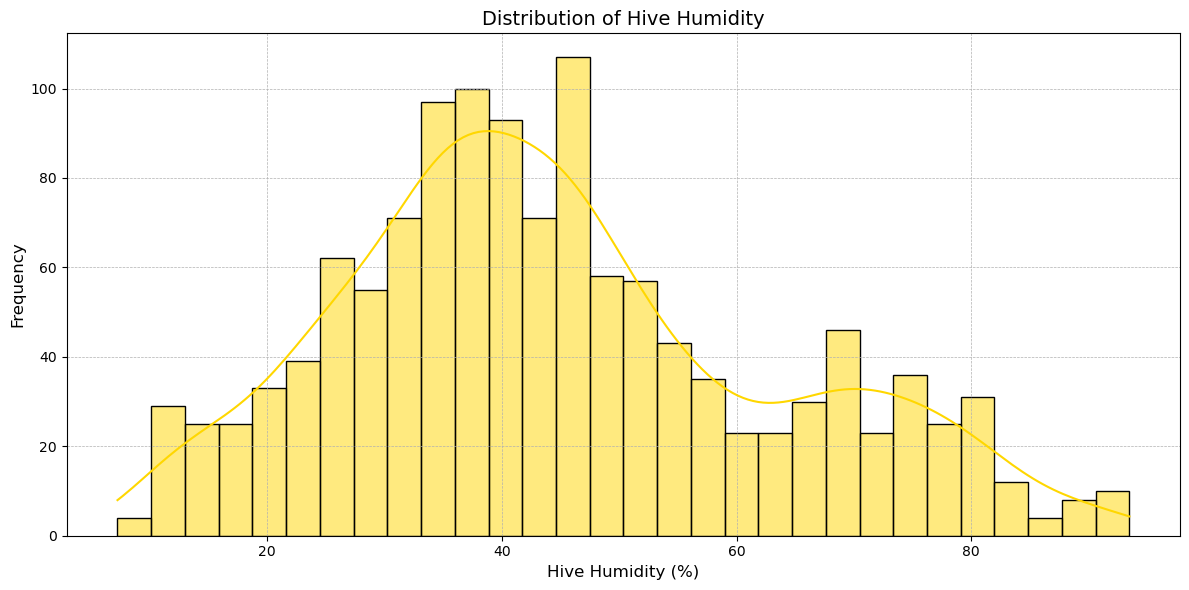

In [98]:
# distribution of hive temperature
plt.figure(figsize=(12, 6))
sns.histplot(beeog['hive temp'], bins=30, kde=True, color='#FFD700', edgecolor='black')
plt.title('Distribution of Hive Temperature', fontsize=14)
plt.xlabel('Hive Temperature (°C)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# distribution of hive humidity
plt.figure(figsize=(12, 6))
sns.histplot(beeog['hive humidity'], bins=30, kde=True, color='#FFD700', edgecolor='black')
plt.title('Distribution of Hive Humidity', fontsize=14)
plt.xlabel('Hive Humidity (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

Checking the average time difference between recordings

In [99]:
# Sort the data by hive number and date
beeog = beeog.sort_values(by=['hive number', 'date'])

# calc the time difference between consecutive recordings 
beeog['time_diff'] = beeog.groupby('hive number')['date'].diff().dt.total_seconds() / 3600  # Convert to hours

# calc  avg time difference for each hive
average_time_diff = beeog.groupby('hive number')['time_diff'].mean().reset_index()

# Rename 
average_time_diff.columns = ['hive number', 'average time between recordings (hours)']

# Display 
average_time_diff

,hive number,average time between recordings (hours)
0,1,1.429819
1,3,1.016312
2,4,1.083298
3,5,1.530729


#### Going further into all queen presence columns

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\880453160.py:18: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


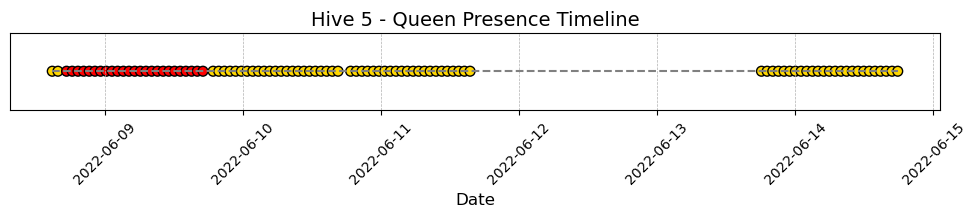

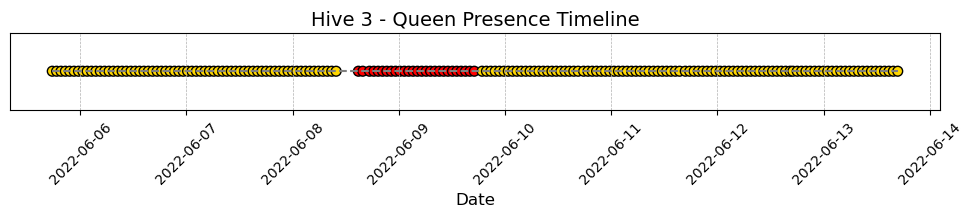

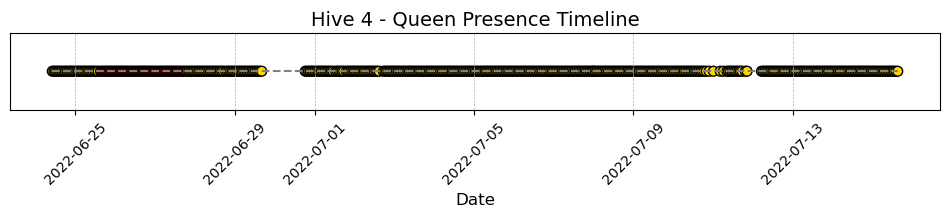

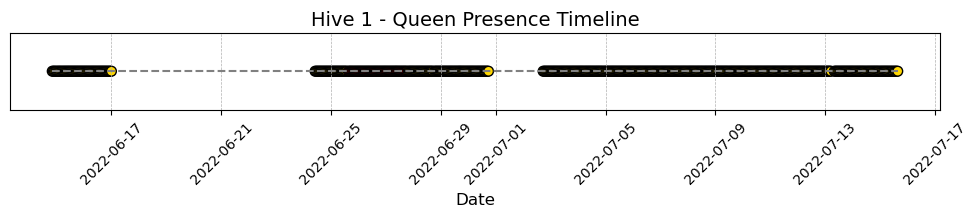

In [116]:
# unique hive numbers
hive_numbers = beeog['hive number'].unique()

# Loop through each hive and plot the timeline for queen presence
for hive in hive_numbers:
    hive_data = beeog[beeog['hive number'] == hive]
    
    #  plot
    plt.figure(figsize=(12, 1))
    plt.hlines(1, hive_data['date'].min(), hive_data['date'].max(), colors='grey', linestyles='dashed')
    plt.scatter(hive_data['date'], [1]*len(hive_data), c=hive_data['queen presence'].map({0: 'red', 1: '#FFD700'}), s=50, edgecolor='black')
    plt.title(f'Hive {hive} - Queen Presence Timeline', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.yticks([])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\2257229903.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


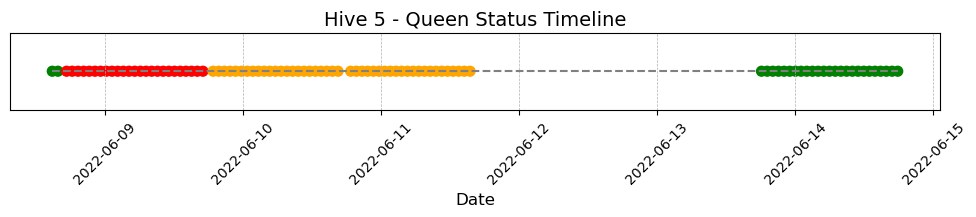

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\2257229903.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


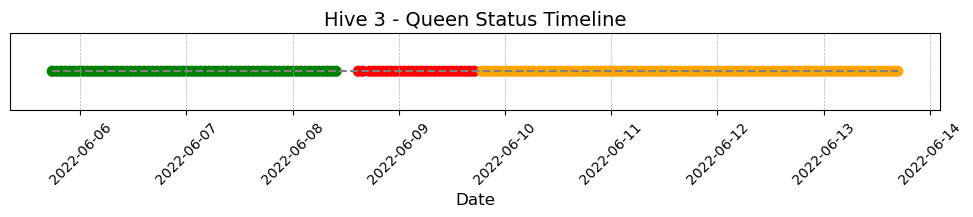

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\2257229903.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


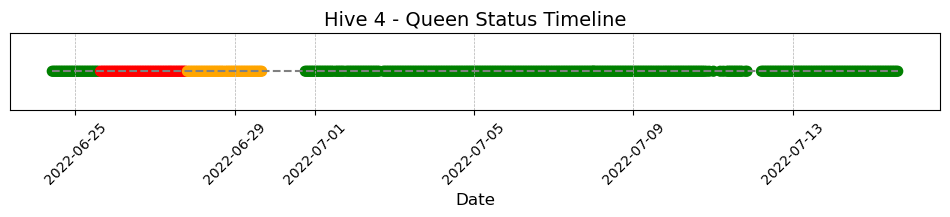

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\2257229903.py:26: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


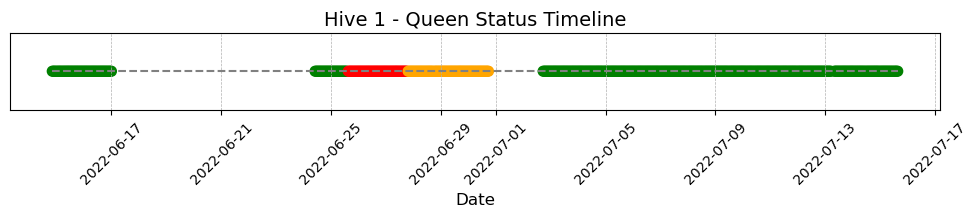

In [122]:
# Define a color map for new queen statuses
color_map = {
    'No Queen': 'red',
    'Queen Present': '#FFD70',  # Yellow
    'Queen Being Introduced (Bad)': 'orange',
    'New Queen Present': 'green'
}

# Get the unique hive numbers
hive_numbers = beeog['hive number'].unique()

# Loop through each hive and plot the timeline for the new queen status
for hive in hive_numbers:
    hive_data = beeog[beeog['hive number'] == hive]
    
    # plot
    plt.figure(figsize=(12, 1))
    plt.hlines(1, hive_data['date'].min(), hive_data['date'].max(), colors='grey', linestyles='dashed')
    plt.scatter(hive_data['date'], [1]*len(hive_data), c=hive_data['new_queen_status'].map(color_map), s=50)
    plt.title(f'Hive {hive} - Queen Status Timeline', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.yticks([])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\495019422.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


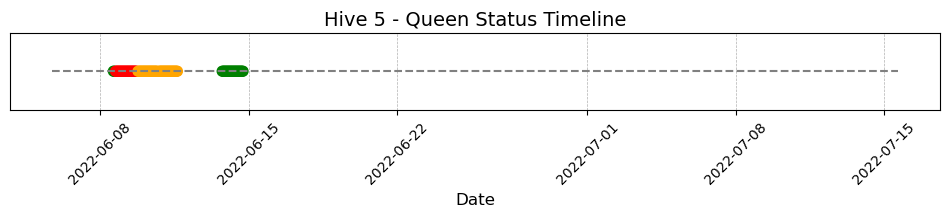

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\495019422.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


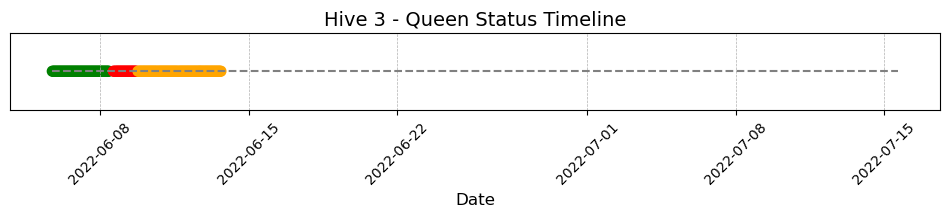

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\495019422.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


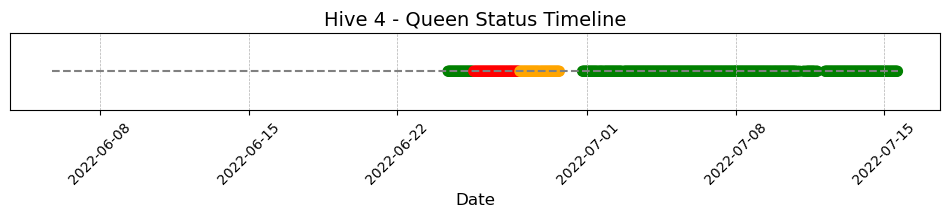

C:\Users\merwe\AppData\Local\Temp\ipykernel_3892\495019422.py:30: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


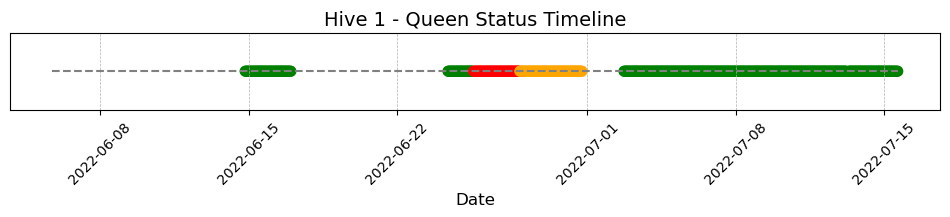

In [124]:
# Define a color map for the new queen statuses
color_map = {
    'No Queen': 'red',
    'Queen Present': '#FFD700',  # Yellow
    'Queen Being Introduced (Bad)': 'orange',
    'New Queen Present': 'green'
}

overall_start_date = beeog['date'].min()
overall_end_date = beeog['date'].max()

hive_numbers = beeog['hive number'].unique()

for hive in hive_numbers:

    hive_data = beeog[beeog['hive number'] == hive]
    
    # plot
    plt.figure(figsize=(12, 1))
    plt.hlines(1, overall_start_date, overall_end_date, colors='grey', linestyles='dashed')
    plt.scatter(hive_data['date'], [1]*len(hive_data), c=hive_data['new_queen_status'].map(color_map), s=50)
    plt.title(f'Hive {hive} - Queen Status Timeline', fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.yticks([])
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()
    plt.show()

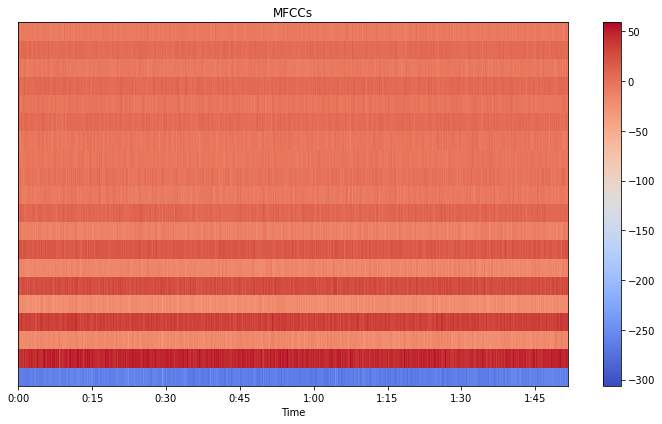

In [1]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Function to extract MFCCs
def extract_mfccs(file_path, frame_length_ms=25, n_mfcc=20, n_mels=40, fmin=50.0, alpha=0.95):
    """
    Extracts MFCCs from an audio file using a Hamming window.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)

        n_fft = int(0.001 * frame_length_ms * sr)
        hop_length = n_fft // 2  # 50% overlap

        y_preemphasized = np.append(y[0], y[1:] - alpha * y[:-1])

        mfccs = librosa.feature.mfcc(
            y=y_preemphasized, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length,
            n_mels=n_mels, fmin=fmin, fmax=sr / 2, window='hamming'
        )

        return mfccs
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, error: {e}")
        return None

# File path 
file_path = r'C:\Users\chris\Desktop\thesis\sound_files\sound_files\2022-06-08--18-20-59_1__segment0.wav'

# Step 1: Extract MFCCs
mfccs = extract_mfccs(file_path)

# Step 2: Plot the MFCCs
if mfccs is not None:
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.tight_layout()
    plt.show()
else:
    print("Error: MFCCs could not be extracted.")

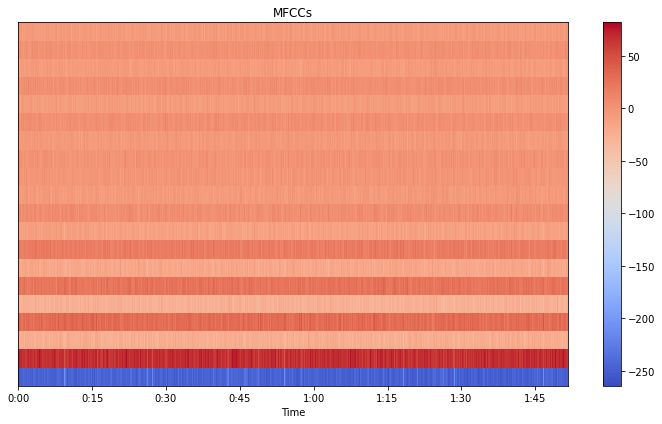

In [3]:

# Function to extract MFCCs 
def extract_mfccs(file_path, frame_length_ms=25, n_mfcc=20, n_mels=40, fmin=50.0, alpha=0.95):
    """
    Extracts MFCCs from an audio file using a Hamming window.
    """
    try:
        y, sr = librosa.load(file_path, sr=None)

        n_fft = int(0.001 * frame_length_ms * sr)
        hop_length = n_fft // 2  # 50% overlap

        y_preemphasized = np.append(y[0], y[1:] - alpha * y[:-1])

        # Compute MFCCs
        mfccs = librosa.feature.mfcc(
            y=y_preemphasized, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length,
            n_mels=n_mels, fmin=fmin, fmax=sr / 2, window='hamming'
        )

        return mfccs
    except Exception as e:
        print(f"Error encountered while parsing file: {file_path}, error: {e}")
        return None

#audio file
file_path = r'C:\Users\chris\Desktop\thesis\sound_files\sound_files\2022-07-15--15-28-21_2__segment2.wav'

# Step 1: Extract MFCCs
mfccs = extract_mfccs(file_path)

# Step 2: Plot 
if mfccs is not None:
    plt.figure(figsize=(10, 6))
    librosa.display.specshow(mfccs, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.tight_layout()
    plt.show()
else:
    print("Error: MFCCs could not be extracted.")